# Reddit Wall Street Bets Sentiment Analysis

<img src="images/reddit.jpg">

### Can we identify outlook for various stocks by analyzing sentiment on these stock tickers and projecting their price movements based on this sentiment?

In [79]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import nltk

from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from nltk.corpus import stopwords

### Data Cleaning

In [3]:
df = pd.read_csv('./reddit_wsb.csv')

In [10]:
df.head()

,title,score,id,url,comms_num,created,body,timestamp
0,"It's not about the money, it's about sending a...",55,l6ulcx,https://v.redd.it/6j75regs72e61,6,1.611863e+09,NaN,2021-01-28 21:37:41
1,Math Professor Scott Steiner says the numbers ...,110,l6uibd,https://v.redd.it/ah50lyny62e61,23,1.611862e+09,NaN,2021-01-28 21:32:10
2,Exit the system,0,l6uhhn,https://www.reddit.com/r/wallstreetbets/commen...,47,1.611862e+09,The CEO of NASDAQ pushed to halt trading “to g...,2021-01-28 21:30:35
3,NEW SEC FILING FOR GME! CAN SOMEONE LESS RETAR...,29,l6ugk6,https://sec.report/Document/0001193125-21-019848/,74,1.611862e+09,NaN,2021-01-28 21:28:57
4,"Not to distract from GME, just thought our AMC...",71,l6ufgy,https://i.redd.it/4h2sukb662e61.jpg,156,1.611862e+09,NaN,2021-01-28 21:26:56


In [11]:
df.describe()

,score,comms_num,created
count,42713.000000,42713.000000,4.271300e+04
mean,1381.296186,205.133168,1.612744e+09
std,8378.625325,2459.724678,1.207035e+06
min,0.000000,0.000000,1.601340e+09
25%,1.000000,2.000000,1.611880e+09
50%,25.000000,12.000000,1.612264e+09
75%,168.000000,45.000000,1.612767e+09
max,348241.000000,93268.000000,1.616263e+09


In [18]:
# Drop unnecessary columns for analysis
df = df.drop(columns=['id', 'url', 'created'])

In [19]:
# Handle missing values
df.isnull().sum()

title            0
score            0
comms_num        0
body         22175
timestamp        0
dtype: int64

In [20]:
# Final data set
df.head(10)

,title,score,comms_num,body,timestamp
0,"It's not about the money, it's about sending a...",55,6,NaN,2021-01-28 21:37:41
1,Math Professor Scott Steiner says the numbers ...,110,23,NaN,2021-01-28 21:32:10
2,Exit the system,0,47,The CEO of NASDAQ pushed to halt trading “to g...,2021-01-28 21:30:35
3,NEW SEC FILING FOR GME! CAN SOMEONE LESS RETAR...,29,74,NaN,2021-01-28 21:28:57
4,"Not to distract from GME, just thought our AMC...",71,156,NaN,2021-01-28 21:26:56
5,WE BREAKING THROUGH,405,84,NaN,2021-01-28 21:26:30
6,SHORT STOCK DOESN'T HAVE AN EXPIRATION DATE,317,53,Hedgefund whales are spreading disinfo saying ...,2021-01-28 21:26:27
7,THIS IS THE MOMENT,405,178,Life isn't fair. My mother always told me that...,2021-01-28 21:19:31
8,Currently Holding AMC and NOK - Is it retarded...,200,161,NaN,2021-01-28 21:19:16
9,I have nothing to say but BRUH I am speechless...,291,27,NaN,2021-01-28 21:18:37


### Exploratory Data Analysis

In [47]:
# Extract titles and bodies of the wsbets posts
vis_df = df[['title', 'body']].copy()
vis_df.head(10)

,title,body
0,"It's not about the money, it's about sending a...",NaN
1,Math Professor Scott Steiner says the numbers ...,NaN
2,Exit the system,The CEO of NASDAQ pushed to halt trading “to g...
3,NEW SEC FILING FOR GME! CAN SOMEONE LESS RETAR...,NaN
4,"Not to distract from GME, just thought our AMC...",NaN
5,WE BREAKING THROUGH,NaN
6,SHORT STOCK DOESN'T HAVE AN EXPIRATION DATE,Hedgefund whales are spreading disinfo saying ...
7,THIS IS THE MOMENT,Life isn't fair. My mother always told me that...
8,Currently Holding AMC and NOK - Is it retarded...,NaN
9,I have nothing to say but BRUH I am speechless...,NaN


In [65]:
# Combine into plain text column
vis_df = vis_df.dropna()
vis_df['combined'] = vis_df['title'] + ' ' + vis_df['body']
vis_df = vis_df.reset_index()

In [66]:
vis_df.head(10)

,index,title,body,combined
0,2,Exit the system,The CEO of NASDAQ pushed to halt trading “to g...,Exit the system The CEO of NASDAQ pushed to ha...
1,6,SHORT STOCK DOESN'T HAVE AN EXPIRATION DATE,Hedgefund whales are spreading disinfo saying ...,SHORT STOCK DOESN'T HAVE AN EXPIRATION DATE He...
2,7,THIS IS THE MOMENT,Life isn't fair. My mother always told me that...,THIS IS THE MOMENT Life isn't fair. My mother ...
3,10,"We need to keep this movement going, we all ca...",I believe right now is one of those rare oppo...,"We need to keep this movement going, we all ca..."
4,12,"Once you're done with GME - $AG and $SLV, the ...",You guys are champs. GME... who would have tho...,"Once you're done with GME - $AG and $SLV, the ..."
5,13,$GME price has nothing to do with fundamentals...,"Firstly, all of you diamond hands and smooth-b...",$GME price has nothing to do with fundamentals...
6,19,"Daily Discussion Thread for January 28, 2021",Your daily trading discussion thread. Please k...,"Daily Discussion Thread for January 28, 2021 Y..."
7,21,We need to stick together and 💎🖐 the ever lovi...,This is our time. If anyone will listen to you...,We need to stick together and 💎🖐 the ever lovi...
8,23,I'm so proud of how far this subreddit has come,I still remember when I first joined and most ...,I'm so proud of how far this subreddit has com...
9,30,Are we ready to attack the Citadel !!!!,https://youtu.be/BtjhgcAMYU0,Are we ready to attack the Citadel !!!! https:...


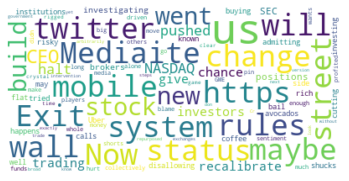

In [69]:
# Start with one post
text = vis_df.combined[0]

# Create and generate a word cloud image:
wordcloud = WordCloud(max_font_size=50, max_words=100, background_color="white").generate(text)

# Display Figure
plt.figure()
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

In [74]:
# Now let's run the same analysis for all posts
text = ' '.join(vis_df.combined)
print ("There are {} words in the combination of all review.".format(len(text)))

There are 22263973 words in the combination of all review.


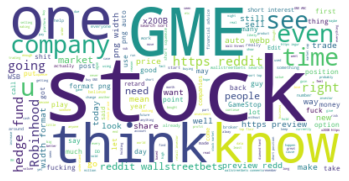

In [83]:
# Create stopword list
stopwords = set(STOPWORDS)
stopwords.update(nltk.corpus.stopwords.words('english'))

# Generate a word cloud image
wordcloud = WordCloud(stopwords=stopwords, background_color="white").generate(text)

# Display the generated image
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()